  Manufacturer    Model  Sales_in_thousands Vehicle_type  Price_in_thousands  \
0        Acura  Integra              16.919    Passenger               21.50   
1        Acura       TL              39.384    Passenger               28.40   
2        Acura       CL              14.114    Passenger                 NaN   
3        Acura       RL               8.588    Passenger               42.00   
4         Audi       A4              20.397    Passenger               23.99   

   Engine_size  Horsepower  Wheelbase  Width  Length  Curb_weight  \
0          1.8       140.0      101.2   67.3   172.4        2.639   
1          3.2       225.0      108.1   70.3   192.9        3.517   
2          3.2       225.0      106.9   70.6   192.0        3.470   
3          3.5       210.0      114.6   71.4   196.6        3.850   
4          1.8       150.0      102.6   68.2   178.0        2.998   

   Fuel_capacity  Fuel_efficiency Latest_Launch  Power_perf_factor  
0           13.2             28.0  

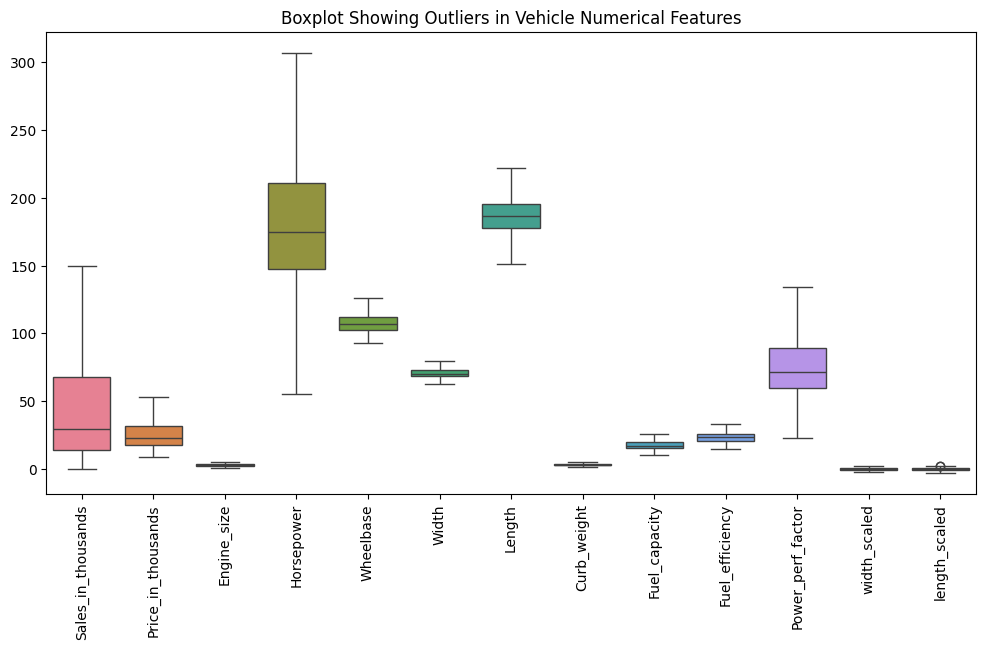

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. LOAD AND INSPECT DATA
df = pd.read_csv("ML470_S7_Vehicle_Data_Practice.csv")

print(df.head())
print(df.info())

# remove missing values
df = df.dropna()

# select numerical columns
num_df = df.select_dtypes(include=[np.number])

# 2. OUTLIER DETECTION USING IQR
outlier_count = {}

for col in num_df.columns:
    Q1 = num_df[col].quantile(0.25)
    Q3 = num_df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = ((num_df[col] < lower) | (num_df[col] > upper)).sum()
    outlier_count[col] = outliers
    
    # Winsorization
    num_df[col] = np.clip(num_df[col], lower, upper)

print("Outliers detected per feature:")
print(outlier_count)

# 3. FEATURE SCALING (Width & Length)
scaler = StandardScaler()
num_df[['width_scaled', 'length_scaled']] = scaler.fit_transform(
    num_df[['Width', 'Length']]
)

# 4. FINAL CLEAN DATASET
final_df = num_df[['width_scaled', 'length_scaled']]

print(final_df.head())

# Dataset ready for:
# - Scatter plots
# - DBSCAN
# - Agglomerative clustering
# - KMeans

plt.figure(figsize=(12,6))
sns.boxplot(data=num_df)
plt.xticks(rotation=90)
plt.title("Boxplot Showing Outliers in Vehicle Numerical Features")
plt.show()


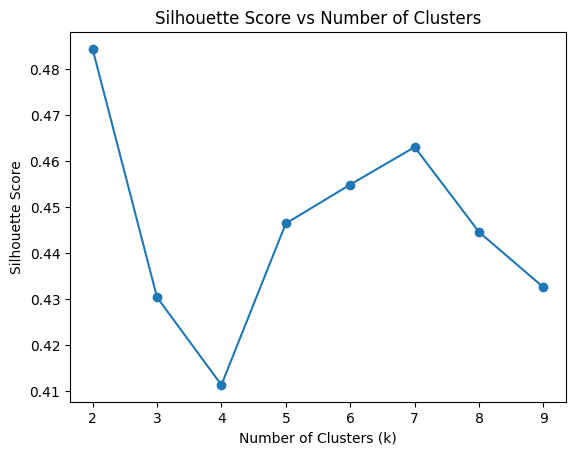

Silhouette scores:
k = 2 → Silhouette Score = 0.484
k = 3 → Silhouette Score = 0.43
k = 4 → Silhouette Score = 0.411
k = 5 → Silhouette Score = 0.446
k = 6 → Silhouette Score = 0.455
k = 7 → Silhouette Score = 0.463
k = 8 → Silhouette Score = 0.445
k = 9 → Silhouette Score = 0.433


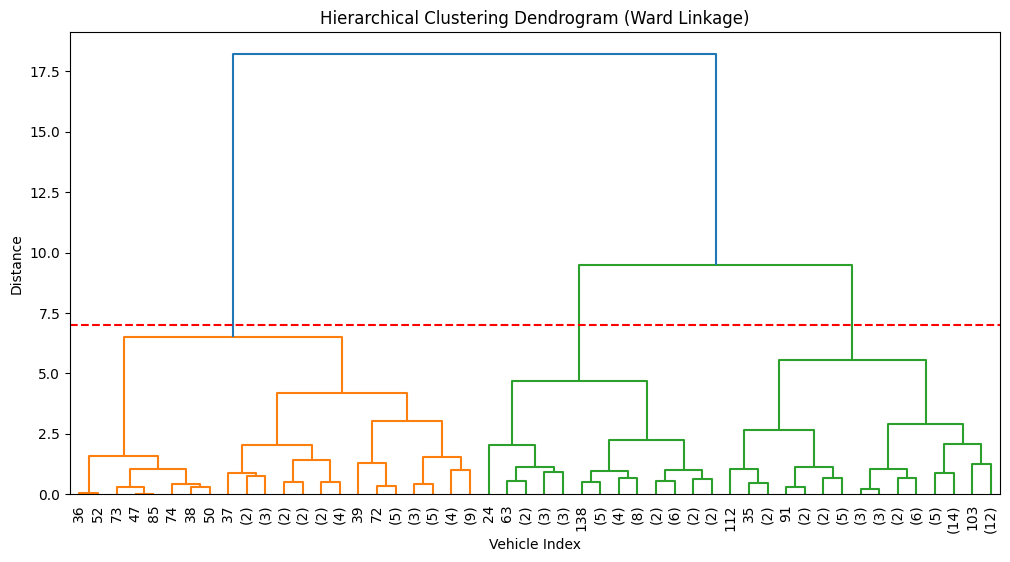

In [4]:
# CLUSTER EVALUATION USING SILHOUETTE SCORE & DENDROGRAM

import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage

# -------------------------------
# 1. SILHOUETTE SCORE ANALYSIS
# -------------------------------

sil_scores = []

K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(final_df)
    score = silhouette_score(final_df, labels)
    sil_scores.append(score)

# Plot silhouette scores
plt.figure()
plt.plot(K, sil_scores, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Number of Clusters")
plt.show()

print("Silhouette scores:")
for k, s in zip(K, sil_scores):
    print(f"k = {k} → Silhouette Score = {round(s,3)}")

# -------------------------------
# 2. HIERARCHICAL DENDROGRAM
# -------------------------------

linked = linkage(final_df, method='ward')

plt.figure(figsize=(12,6))
dendrogram(
    linked,
    truncate_mode='level',
    p=5,
    leaf_rotation=90,
    leaf_font_size=10
)

plt.axhline(y=7, color='r', linestyle='--')  # threshold line
plt.title("Hierarchical Clustering Dendrogram (Ward Linkage)")
plt.xlabel("Vehicle Index")
plt.ylabel("Distance")
plt.show()


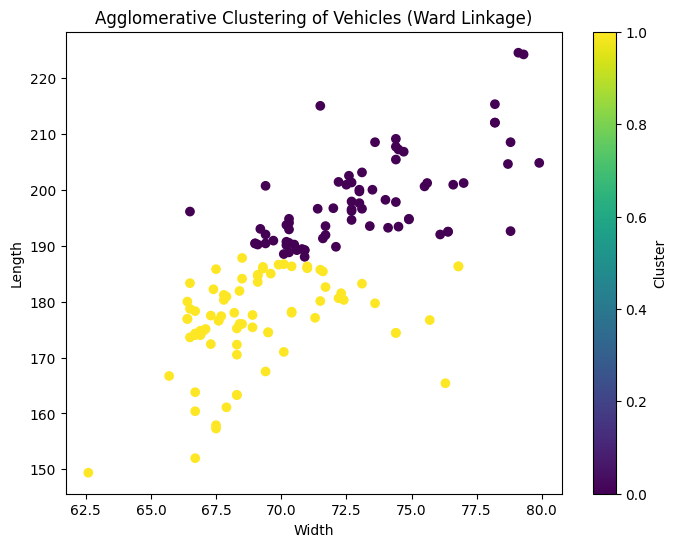

In [7]:
agg = AgglomerativeClustering(
    n_clusters=2,
    linkage='ward'
)

# fit using original Width and Length
df['Cluster'] = agg.fit_predict(df[['Width', 'Length']])

# scatter diagram
plt.figure(figsize=(8,6))
plt.scatter(
    df['Width'],
    df['Length'],
    c=df['Cluster'],
    cmap='viridis'
)

plt.xlabel("Width")
plt.ylabel("Length")
plt.title("Agglomerative Clustering of Vehicles (Ward Linkage)")
plt.colorbar(label="Cluster")
plt.show()

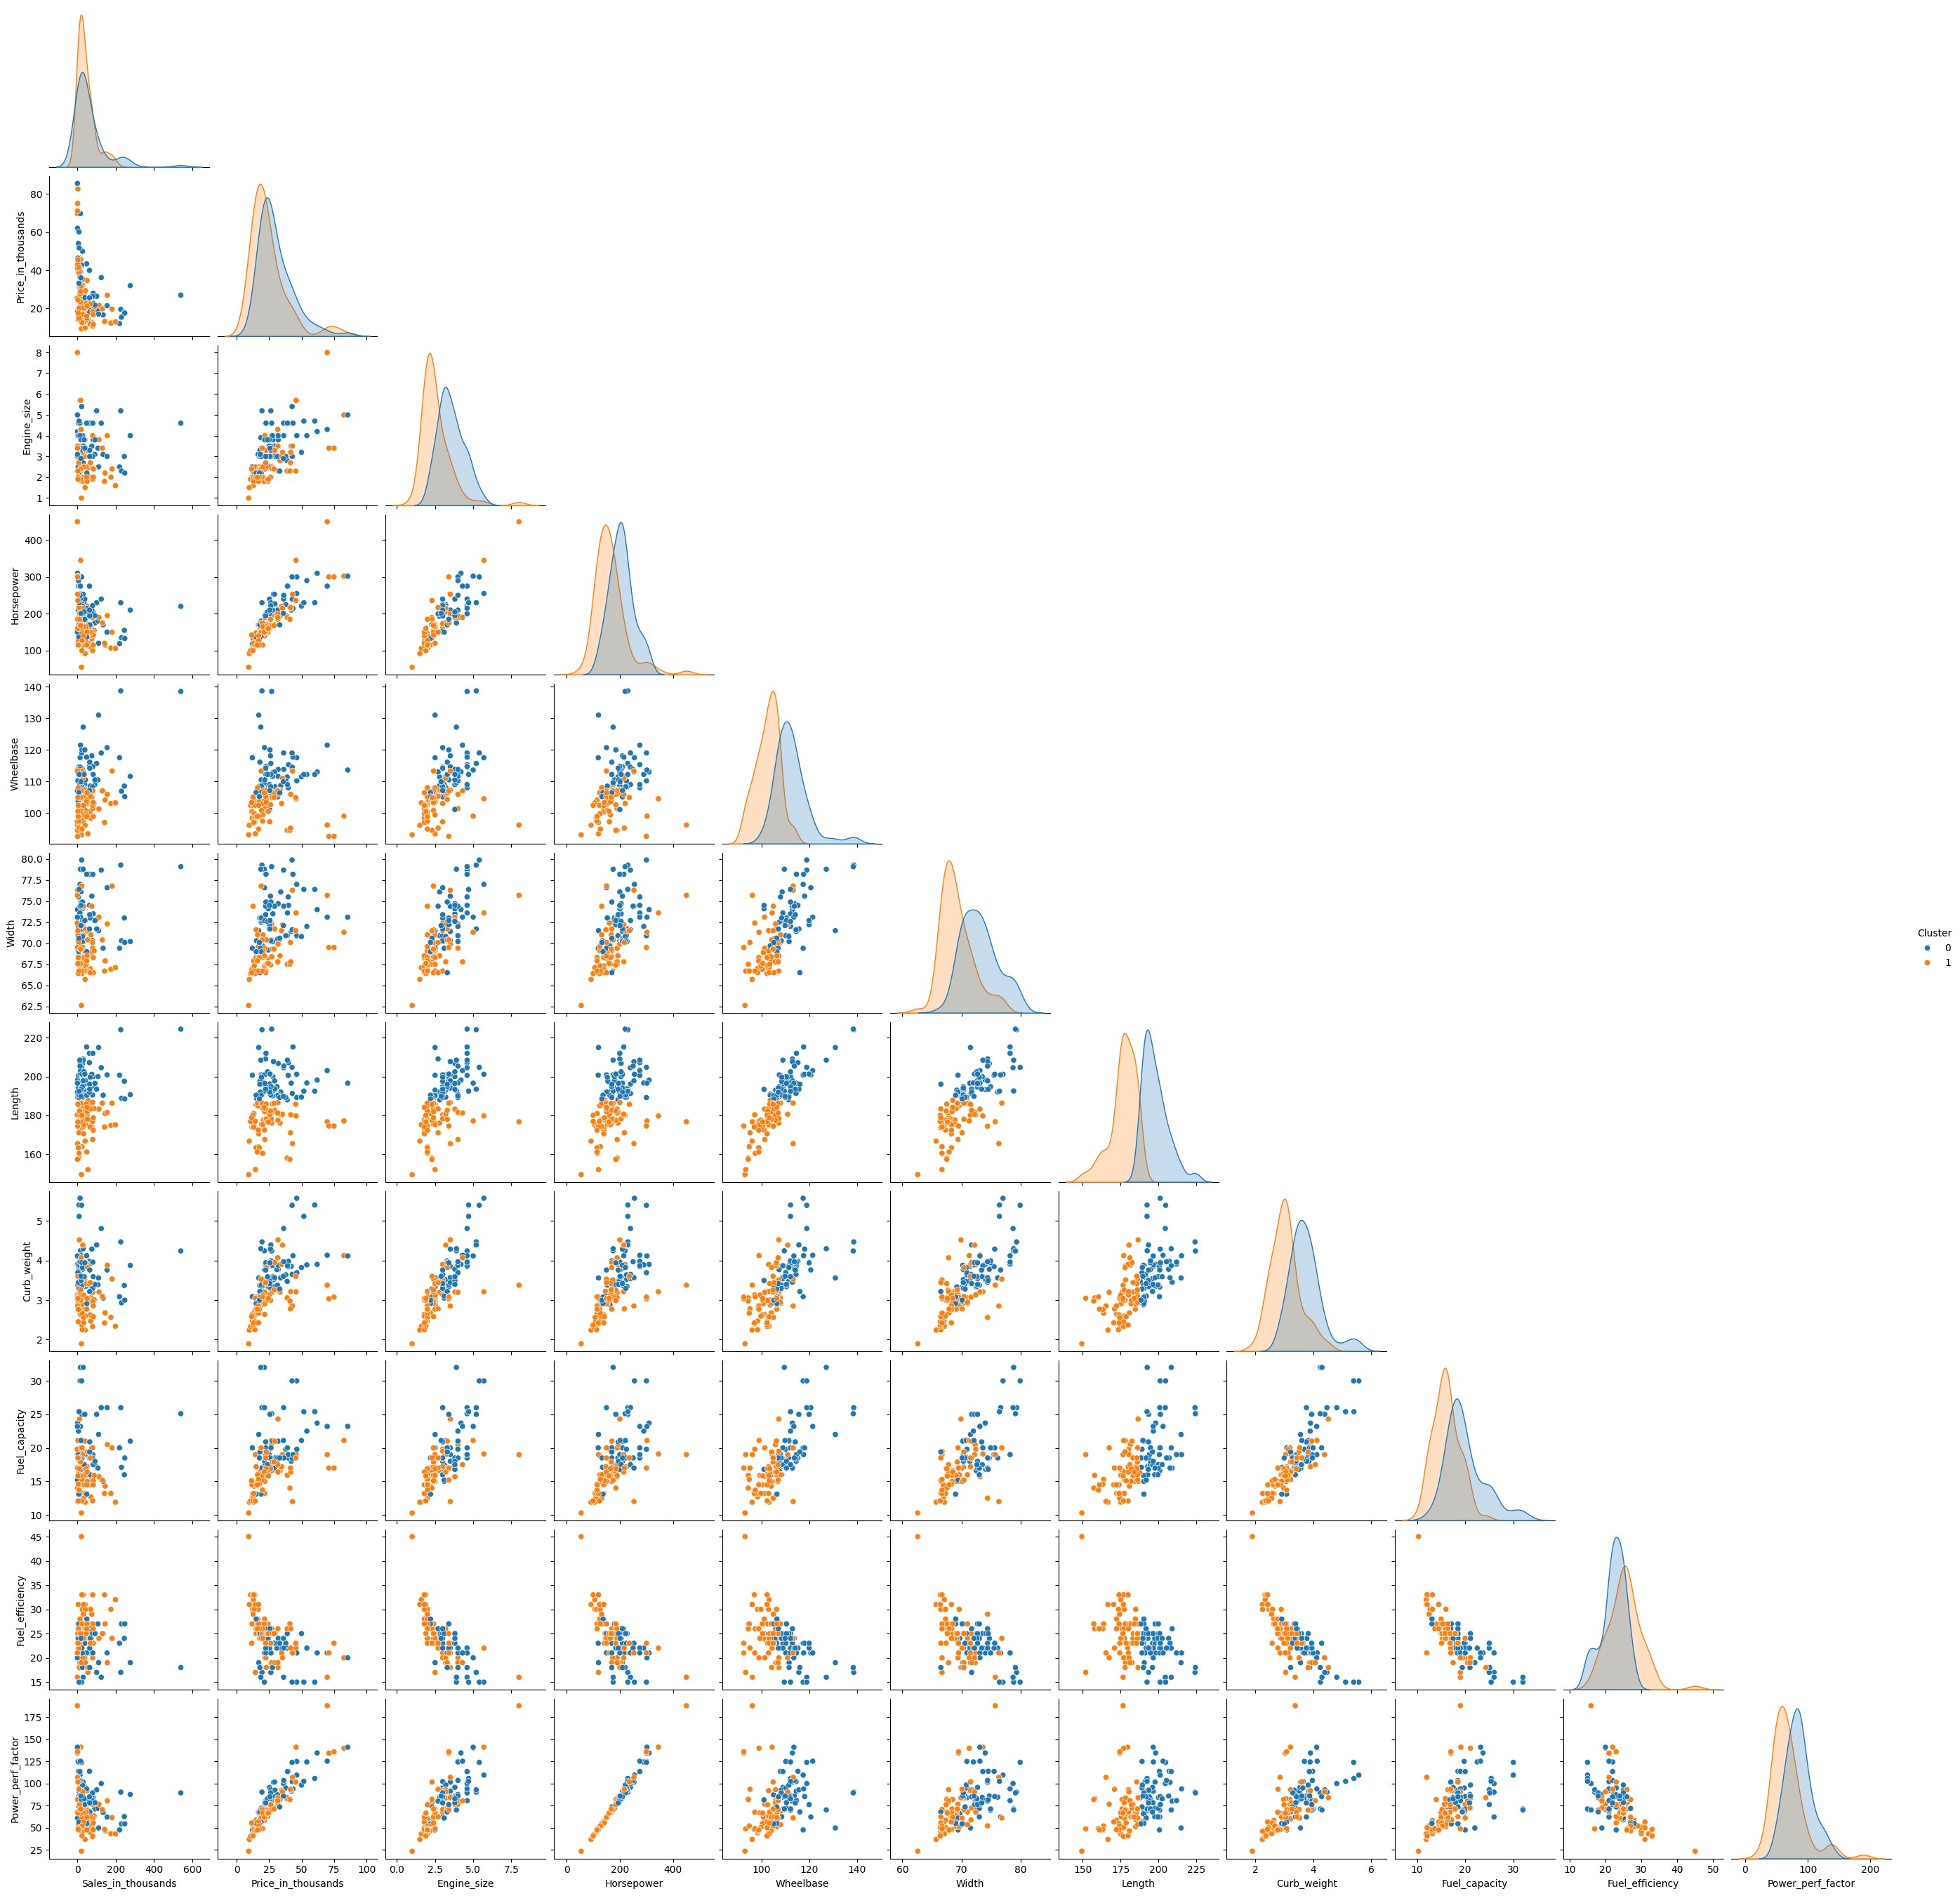

<Figure size 500x300 with 0 Axes>

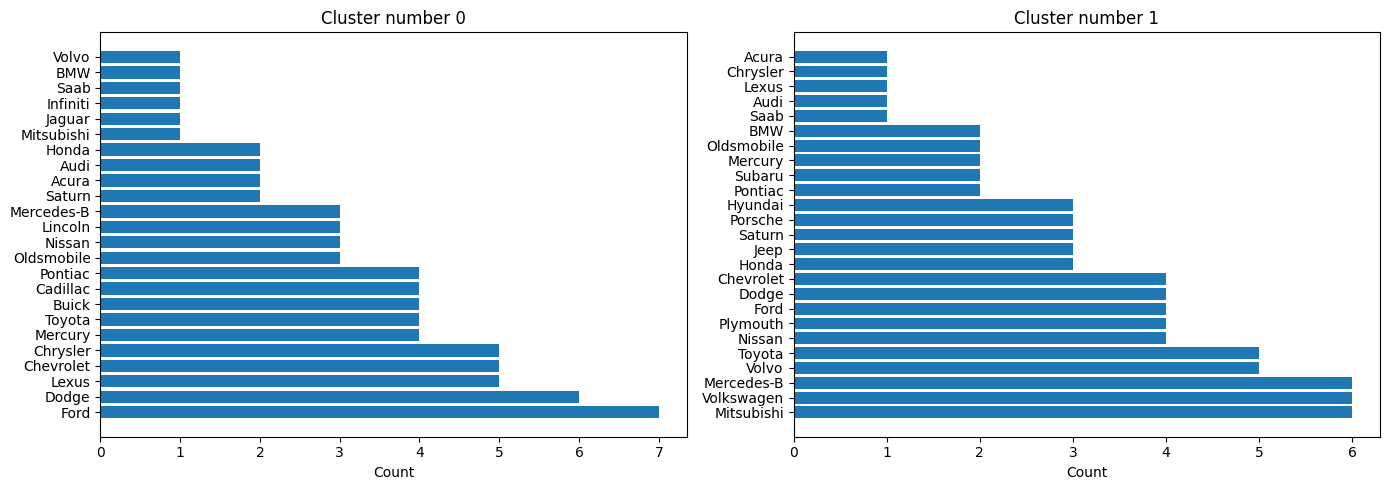

In [12]:
sns.pairplot(
    df,
    hue='Cluster',
    corner=True,
    diag_kind='kde'
)
plt.figure(figsize=(5,3))
plt.suptitle("Pairplot of Vehicle Features by Cluster", y=1.02)
plt.show()

clusters = sorted(df['Cluster'].unique())

fig, axes = plt.subplots(1, len(clusters), figsize=(14,5))

for i, c in enumerate(clusters):
    cluster_data = df[df['Cluster'] == c]
    counts = cluster_data['Manufacturer'].value_counts()

    axes[i].barh(counts.index, counts.values)
    axes[i].set_title(f"Cluster number {c}")
    axes[i].set_xlabel("Count")

plt.tight_layout()
plt.show()